# Pass Sonars

This notebook looks at plotting *Passing Sonars* based off [this article](https://totalfootballanalysis.com/data-analysis/data-analysis-france-south-korea-tactical-analysis-statistics).

In [1]:
# Importing packages and data
from importing_sb import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class
from matplotlib.patches import Arc
from matplotlib.projections.polar import RadialTick

data_dir = 'data/open-data/data/'

comp_data = open_data(data_dir + 'competitions.json')
lineup_data = open_data(data_dir + 'lineups/22921.json')
#match_data = open_data(data_dir + 'matches/22921.json')
data = open_data(data_dir + 'events/22921.json')
df = json_normalize(data)

passes = df[df['type.name'] == 'Pass']

In [2]:
df.filter(like='tactics');

Getting player names for analysis and nicknames for plotting.

In [3]:
# Get player nicknames for plotting
nicknames = {}
for players in lineup_data[1]['lineup']:
    if players['player_nickname'] == None:
        nicknames[str(players['player_name'])] = str(players['player_name'])
    else:
        nicknames[str(players['player_name'])] = str(players['player_nickname'])

In [4]:
# Get player names
player_dict = {}

klist = []

for player in df['tactics.lineup'][0]:
    name = player['player']['name']
    klist.append(name)

Now assign players to a base location on the pitch. (It would be good to have a preset of locations for each formation)

In [5]:
# Assign player to base location
ylist = [0,25,25,25,25,50,50,75,75,100,100]
xlist = [40,10,30,50,70,30,50,30,50,30,50]

for x,y,z in zip(xlist, ylist, klist):
    entry = {z:[x,y]}
    player_dict.update(entry)

Define a function to, for a given player, sort their passes in bins based off the angle of the pass. Then find the average pass length and the fraction of passes in each bin.

In [6]:
# Function to sort passes into angle bins, find average pass length in those bins
# and fraction of passes in each bin
def Passer(player):
    local_df = df.copy()
    local_df = local_df[(local_df["type.name"] == "Pass")&(local_df["player.name"] == str(player))]
    local_df = local_df.dropna(axis='columns', how='all')
    
    df1 = local_df[['pass.angle','pass.length']].copy()
    bins = np.linspace(-np.pi,np.pi,12)
    
    df1['binned'] = pd.cut(local_df['pass.angle'], bins, include_lowest=True, right=True)
    df1['Bin_Mids'] = df1['binned'].apply(lambda x: x.mid) # Find bin mids
    #df1 = df1[:-1]
    
    # Group passes by their bin and find the average pass length in those bins
    df2 = df1.groupby('Bin_Mids', as_index=False)['pass.length'].mean()
    df2 = df2.dropna(axis='index')
    
    # Find fraction of passes in each bin
    groups = df1.groupby('Bin_Mids', as_index=False)
    pass_frac = groups.size()/len(df1) # groupby().size() finds number of passes in each bin
    pass_frac = pass_frac[pass_frac != 0].values
    
    df2['pass_frac'] = pass_frac
    
    return df2

Finally plot the radars for the whole team. The fraction of total passes is the radius and the colour is the average length of the pass in that bin.

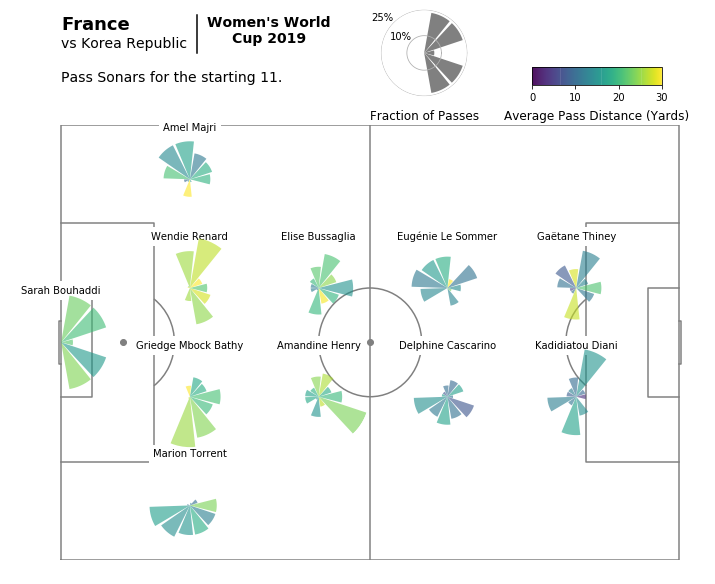

In [9]:
# Using number of passes for radius and length of pass for colour
import matplotlib

fig, ax = draw_pitch('w', '0.5', 'h', 'f')

ax.set_ylim(0,80)
ax.set_xlim(-5,125)

# Define a function which creates an inset axes, i.e. the radar for a player
def plot_inset(width, axis_main, data, x, y):
    ax_sub = inset_axes(axis_main, width=width, height=width, loc='center',
                       bbox_to_anchor=(x,y),
                       bbox_transform=axis_main.transData,
                       borderpad=0.0, axes_class=get_projection_class("polar"))

    theta = data["Bin_Mids"]
    radii = data["pass_frac"]
    p_length = data['pass.length']
    bars = ax_sub.bar(theta, radii, width=0.5, bottom=0.0)

    ax_sub.set_ylim(0,0.25)
    ax_sub.set_xticklabels([])
    ax_sub.set_yticks([])
    ax_sub.yaxis.grid(False)
    ax_sub.xaxis.grid(False)
    ax_sub.spines['polar'].set_visible(False)
    ax_sub.set_theta_zero_location('E')
    ax_sub.patch.set_alpha(0)  # Sets the axis backgrounds alpha
    
    # Colour the bars according to average pass length
    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=0,vmax=30)
    for p, bar in zip(p_length, bars):
        bar.set_facecolor(cmap(norm(p)))
        bar.set_alpha(0.6)
    
    return ax_sub

# Plotting the radar of each player
for player, loc in player_dict.items():
    plot_inset(1.4, ax, data = Passer(str(player)), x = loc[1], y = loc[0])
    ax.text(loc[1], loc[0]+9, nicknames[player], size=10, ha='center',backgroundcolor='w')

# Adding the radar legend
ax2 = fig.add_axes([0.5,0.93,0.15,0.15],projection='polar')
a = Passer(klist[0])
ax2.bar(a['Bin_Mids'], a['pass_frac'],width=0.5,color='0.5')
ax2.set_rlim(0,0.25)
ax2.set_rgrids([0.1,0.25],['10%','25%'],angle=135,ha='right',va='bottom')
ax2.set_thetagrids([],labels=[])
#ax2.grid(color='k')
ax2.spines['polar'].set_visible(False)
ax2.text(0.5,-0.15,"Fraction of Passes",transform=ax2.transAxes,ha='center',va='top',fontsize=12)

# Adding the colourbar legend
ax3 = fig.add_axes([0.7,0.95,0.15,0.03])
norm_range = plt.Normalize(vmin=0,vmax=30)
cbar = matplotlib.colorbar.ColorbarBase(ax3,cmap=plt.cm.get_cmap('viridis'), norm=norm_range, 
                                        orientation="horizontal",alpha=0.6)
cbar.set_ticks([0,10,20,30])
ax3.text(0.5,-1.4,"Average Pass Distance (Yards)",transform=ax3.transAxes,ha='center',va='top',fontsize=12)

# Other text annotations
axy = max(ax.get_ylim())-min(ax.get_ylim())
axx = min(ax.get_xlim())
team = ax.text(axx+5,axy+(axy*0.22),"France",fontsize=18,fontweight='semibold')
opp = ax.text(axx+5,axy+(axy*0.18),"vs Korea Republic",fontsize=14)
plt.draw() # Must include otherwise get_window_extent doesn't work as the text hasn't been drawn

#Finding the max x and y of the bbox for the team/opposition
x, y = zip(team.get_window_extent().max, opp.get_window_extent().max)
x = max(x)
y = max(y)
xa, ya = ax.transAxes.inverted().transform([x,y])
xd, yd = ax.transData.inverted().transform([x,y]) # Convert from display to data units

ax.text(xd+(0.16*xd),yd,"Women's World\nCup 2019",fontsize=14,va='top',fontweight='semibold',multialignment='center')
ax.axvline(xd+(0.08*xd),0.93*ya,ya,clip_on=False,c='k')

ax.text(axx+5,axy+(axy*0.10),"Pass Sonars for the starting 11.",fontsize=14)

plt.show()